# Задача 3. QR-разложение и неустойчивость метода Грама-Шмидта (30 баллов)

В этой задаче мы реализуем два метода вычисления QR-разложения и исследуем их поведение на различных матрицах.

**Обратите внимание:** <font color='red'>во всех пунктах данной задачи не допускается использовать циклы вложенности больше 1, вместо вложенных циклов используйте функции из `numpy`.</font>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### a. (10 баллов) Метод Грама-Шмидта

Реализуйте метод Грама-Шмидта (функцию `gram_schmidt_QR`) для ортогонализации столбцов матрицы $A\in\mathbb{R}^{m\times n}$.

In [2]:
# вжух, будущий я:
# для удобства напишем свой нормализатор, чтобы ноль не проверять каждый раз
def normalize(a):
    norm = np.linalg.norm(a)
    if norm != 0:
        return a / norm
    return a

In [3]:
def gram_schmidt_QR(A):
    """
        Input
            A: m x n matrix with m >= n
            
        Output
            Q: m x n matrix with orthonormal columns
            R: n x n upper triangular matrix
    """
    a_0 = A[np.newaxis,:,0].T
    Q = normalize(a_0)
    for k in range(1, A.shape[1]):
        a_k = A[np.newaxis,:,k].T
        q = a_k - Q @ Q.T @ a_k
        q = normalize(q)
        Q = np.hstack((Q, q))

    return Q, Q.T @ A

In [4]:
A = np.array([[1,2],[2,3],[3,4]])
print(gram_schmidt_QR(A))

(array([[ 0.26726124,  0.87287156],
       [ 0.53452248,  0.21821789],
       [ 0.80178373, -0.43643578]]), array([[ 3.74165739e+00,  5.34522484e+00],
       [-5.32907052e-15,  6.54653671e-01]]))


Проверим на наличие возможных багов.

In [5]:
def test_QR(A, QR):
    Q, R = QR
    m, n = A.shape
    assert m >= n
    non_orthogonality = np.linalg.norm(Q.T @ Q - np.eye(n))
    print("||Q^TQ - I||_F = {}".format(non_orthogonality))
    for i in range(n):
        if np.linalg.norm(R[i + 1:, i]) > 1e-9:
            print("Achtung! Nonzero under main diagonal of R!")
            return
    error = np.linalg.norm(Q @ R - A)
    print("||A - QR||_F = {}".format(error))

In [6]:
np.random.seed(42)
m, n = 50, 20
A = np.random.randn(m, n)
test_QR(A, gram_schmidt_QR(A))

||Q^TQ - I||_F = 1.2323252707402384e-15
||A - QR||_F = 8.057442426633511e-15


### b. (15 баллов) Метод отражений (преобразований Хаусхолдера)

- (5 баллов) Реализуйте вычисление QR-разложения с помощью преобразования Хаусхолдера. Возвращать мы будем не матрицу $Q$, как в предыдущей задаче, а матрицу, состоящую из столбцов $w_1, \dots, w_n$ (для максимальной эффективности можно было бы упаковать все $w_i$ и матрицу $R$ в одну $m\times n$ матрицу, так как обе содержат одинаковое количество нулей) таких, что $$
H(w_n)\dots H(w_1)A = \begin{bmatrix}R \\ 0\end{bmatrix},
$$ где $H(u)$ &mdash; преобразование Хаусхолдера, заданное вектором $u$. Мы также потребуем, чтобы для всех $i$ выполнялось $\|w_i\|_2 = 1$. 

In [7]:
def house(A):
    """
        Input
            A: m x n matrix with m >= n
            
        Output
            W: m x n lower triangular matrix with columns
               representing Householder reflections, i.e. Q = H(W[:,0]) @ ... @ H(W[:, -1])
            R: n x n upper triangular matrix
    """
    m, n = A.shape
    W = None
    for k in range(n):
        a_k = A[np.newaxis, k:, k].T
        if (np.linalg.norm(a_k) == 0):
            v_k = np.zeros((m-k, 1))
        else:
            gamma = -np.sign(a_k[0,0])
            e_1 = np.zeros((m-k, 1))
            e_1[0,0] = 1
            v_k = a_k - gamma * np.linalg.norm(a_k) * e_1
            v_k = normalize(v_k)
        w_k = np.vstack((np.zeros((k, 1)), v_k))
        
        H_k = np.eye(m) - 2 * (w_k @ w_k.T)
        A = H_k @ A
        if W is None:
            W = w_k
        else:
            W = np.hstack((W, w_k))

    R = A[:n, :n]
    return W, R

- (5 баллов) Также нам понадобится функция, восстанавливающая $Q$ по $W$. Сначала сделаем совсем просто: вычислим унитарную $Q \in \mathbb{R}^{m \times m}$, равную $H(w_1) \dots H(w_k)$. Сложность этой функции должна быть $O(m^2n)$.

In [8]:
def form_full_Q(W):
    """
        Input
            W: m x n lower triangular matrix with m >= n
            
        Output
            Q: m x m orthogonal matrix, Q = H(w_1)...H(w_k)
    """
    Q = np.eye(W.shape[0])
    for k in range(W.shape[1]):
        w_k = W[np.newaxis, :,W.shape[1] - k - 1].T
        Q = Q - 2 * w_k @ (w_k.T @ Q)

    return Q

Теперь мы можем реализовать QR-разложение с помощью отражений Хаусхолдера.

In [9]:
def house_QR_naive(A):
    m, n = A.shape
    W, R = house(A)
    full_Q = form_full_Q(W)
    Q = full_Q[:, :n]
    return Q, R

Как и раньше, проверим, что не закралось каких-то простых багов.

In [10]:
np.random.seed(42)
m, n = 50, 20
A = np.random.randn(m, n)
test_QR(A, house_QR_naive(A))

||Q^TQ - I||_F = 2.3964346679751287e-15
||A - QR||_F = 2.4191367208155366e-14


- (5 баллов) Теперь оптимизируем вычисление матрицы $Q$. В функции `house_QR_naive` мы вычисляем полную матрицу $Q_{full} \in \mathbb{R}^{m \times m}$, а потом выкидываем последние $m - n$ столбцов. Это может быть очень трудозатратно в случае, если $m \gg n$. Напишите функцию `form_Q`, которая будет сразу возвращать матрицу $Q$ нужных размером ($m \times n$). Воспользуйтесь тем, что искомая матрица $Q$ удовлетворяет равенству $$
Q = H(w_1) \dots H(w_n) \begin{bmatrix}I_n\\0\end{bmatrix}.
$$
Функция должна иметь сложность $O(mn^2)$.

In [11]:
def form_Q(W):
    """
        Input
            W: m x n lower triangular matrix with m >= n
            
        Output
            Q: m x n matrix with orthonormal columns, Q = (H(w_1)...H(w_k))[:, :n]
    """
    Q = np.eye(N=W.shape[0], M=W.shape[1])
    for k in range(W.shape[1]):
        w_k = W[np.newaxis, :,W.shape[1] - k - 1].T
        Q = Q - 2 * w_k @ (w_k.T @ Q)
    
    return Q

Теперь можем написать **не**наивную версию алгоритма отражений.

In [12]:
def house_QR(A):
    W, R = house(A)
    return form_Q(W), R

Снова проверим адекватность метода на случайной матрице.

In [13]:
np.random.seed(42)
m, n = 50, 20
A = np.random.randn(m, n)
test_QR(A, house_QR(A))

||Q^TQ - I||_F = 2.3964346679751287e-15
||A - QR||_F = 2.4191367208155366e-14


### c. (5 баллов) Сравнение двух методов вычисления QR-разложения

Сначала сравним точность методов на случайных квадратных матрица порядка $100$.

In [14]:
def get_errors(A, QR):
    m, n = A.shape
    Q, R = QR
    return np.linalg.norm(Q @ R - A), np.linalg.norm(Q.T @ Q - np.eye(n))
    
gs_errors, gs_ortho_errors = [], []
house_errors, house_ortho_errors = [], []

iters = 100
np.random.seed(42)
for _ in range(iters):
    A = np.random.randn(m, n)
    err, ortho_err = get_errors(A, gram_schmidt_QR(A))
    gs_errors.append(err)
    gs_ortho_errors.append(ortho_err)
    err, ortho_err = get_errors(A, house_QR(A))
    house_errors.append(err)
    house_ortho_errors.append(ortho_err)

In [15]:
print("Gram-Schmidt: ||A - QR||_F = {}, ||Q^TQ - I||_F = {}".format(np.mean(gs_errors), np.mean(gs_ortho_errors)))
print("Householder:  ||A - QR||_F = {}, ||Q^TQ - I||_F = {}".format(np.mean(house_errors), np.mean(house_ortho_errors)))

Gram-Schmidt: ||A - QR||_F = 8.396483491647537e-15, ||Q^TQ - I||_F = 1.1797511853357274e-15
Householder:  ||A - QR||_F = 2.4968989701395752e-14, ||Q^TQ - I||_F = 2.1694395388150036e-15


Какой метод работает лучше для случайных матриц?

ОГШ лучше работает "в среднем", но не намного: обе ошибки - как ошибка приближения исходной матрицы, так и ошибка ортогональности полученной системы - сравнимы по порядку, отличаются на малую константу.

Теперь посмотрим что происходит при ортогонализации столбцов матрицы Гильберта.

In [16]:
import scipy.linalg

A = scipy.linalg.hilbert(100)
print("Gram-Schmidt: ||A - QR||_F = {}, ||Q^TQ - I||_F = {}".format(*get_errors(A, gram_schmidt_QR(A))))
print("Householder:  ||A - QR||_F = {}, ||Q^TQ - I||_F = {}".format(*get_errors(A, house_QR(A))))

Gram-Schmidt: ||A - QR||_F = 1.9395610454280787, ||Q^TQ - I||_F = 92.8817214650035
Householder:  ||A - QR||_F = 1.5037028471622175e-15, ||Q^TQ - I||_F = 9.572787608358248e-15


Сделайте выводы о работе метода в данном случае.

А вот здесь проявляется численная неустойчивость ОГШ, то есть чувствительность к какому-то особому типу входных данных. В данном случае ОГШ выдаёт ошибки на ~15 порядков хуже, чем метод Хаусхольдера.

# Задача 4. Быстрое вычисление дискретной свертки (45 баллов)

В этой задаче мы научимся эффективно вычислять **свёртку** изображения на примере одного из самых известных фильтров &mdash; фильтра Гаусса (подзадачи a., b., c.), а также попробуем восстановить исходное изображение из размытого (подзадача d.).

**Обратите внимание:** <font color='red'>во всех пунктах данной задачи запрещается использовать циклы.</font>

Начнем с эффективного применение фильтра Гаусса

Загрузим изображение (в виде матрицы $A$), с которым будем работать. Будем использовать одну из классических фотографий, применяемых для тестирования алгоритмов обработки изображений: "cameraman". 

(256, 256)


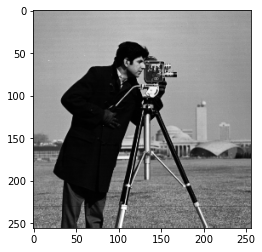

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
%matplotlib inline

A = imread('data/cameraman.tif').astype(np.float)
print(A.shape)
_ = plt.imshow(A, cmap='gray')

Мы будем учиться применять к картинке [фильтр Гаусса](https://en.wikipedia.org/wiki/Gaussian_blur), чтобы получить в итоге что-то вроде следующего изображения. 

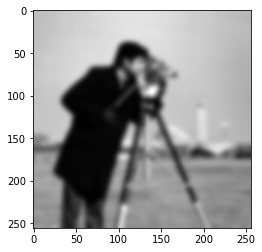

In [18]:
from scipy.ndimage import gaussian_filter
B = gaussian_filter(A, 3)
_ = plt.imshow(B, cmap='gray')

### a. (10 баллов) Формулировка задачи

При это преобразовании каждый пиксель картинки заменяется на взвешенную сумму соседних пикселей (вообще говоря, всех остальных пикселей картинки), причём вес пикселя со смещением $\Delta x$ и $\Delta y$ относительно данного есть $$
G(\Delta x, \Delta y) = \frac{1}{2\pi\sigma^2}\exp\left(-\frac{\Delta x^2 + \Delta y^2}{2\sigma^2}\right).
$$
Это называется двумерной **свёрткой** картинки с фильтром Гаусса (обычно при этом считается, что картинка продолжена за края каким-то образом, например, отражена, чтобы пиксели размытой картинки у краёв не имели меньшую яркость. Но мы не будем реализовывать этот эффект).

На матричном языке это можно записать как умножение двухуровневой Теплицевой матрицы $T^{(2D)}$ на векторизованную картинку $\mathrm{vec}(A)$: 

$$\mathrm{vec}(B) = T^{(2D)} \mathrm{vec}(A),$$ 

где $B$ является картинкой после применения фильтра.


- **(3 балла)** Выпишите асимптотику сложности вычисления свёртки без учета теплицевой структуры матрицы $T^{(2D)}$, если размеры картинки $m \times n$.

**Ответ:** Если не использовать тёплицову структуру матрицы, то асимптотика вычислений составит $O(m^2 n^2)$: мы перемножаем квадратную $mn \times mn$ матрицу на вектор размера $mn \times 1$.



**Замечание:** Мы могли бы вычислить свертку $T^{(2D)} \mathrm{vec}(A)$, вложив $T^{(2D)}$ в блочный циркулянт с циркулянтными блоками и применив двумерное преобразование Фурье. Однако фильтр $G(\Delta x, \Delta y)$ обладает дополнительной структурой, которую можно использовать. А именно, он является *сепарабельным*: 
$$G(\Delta x, \Delta y) = G (\Delta x) G (\Delta y),$$
где 
$$
G(u) = \frac{1}{\sigma\sqrt{2\pi}}\exp\left(-\frac{u^2}{2\sigma^2}\right).
$$

- **(7 баллов)** Сепарабельность фильтра позволяет дополнительно упростить вычисления. Покажите (решение можно записать в этом файле или в теоретической части задания), что $T^{(2D)} = T_n \otimes T_m$, где $T_n$ является некоторой Теплицевой матрицей порядка $n$. А именно, запишите элементы $T_n$ с использованием функции $G(u)$.

Матрицу $T^{(2D)}$ можно разложить следующим образом:

1) Исходное изображение A имеет m рядов и n столбцов пикселей, значит, в векторной форме оно имеет вид "n столбцов (секторов) длины m, поставленные друг на друга". Это значит, что $T^{(2D)}$ имеет блочный размер $n \times n$, а каждый блок, в свою очередь, размер $m \times m$; 

2) Обозначим разницу с текущим пикселем в строках как $\Delta x$, разницу в столбцах как $\Delta y$. Тогда внутри кажого из блоков изменение идёт по строковой координате, а $\Delta y$ меняется лишь когда перескакиваем между блоками (это изменение соответствует смене сектора в $Vec(A)$).

3) Иначе говоря, k-я строка $T^{(2D)}$ строится так: в ячейки матрицы будем записывать пары $(\Delta x, \Delta y)$, отвечающие произведению соответствующих функций $G(u)$. k-я строка отвечает за изменение k-го пикселя в $Vec(A)$. Пусть в оригинальной картинке он имел координаты (p, q), то есть k = (q - 1)m + p. Определяем, в каком по счёту секторе $Vec(A)$ (столбце изображения A) он находится, в соответствующий сектор k-й строки записываем $\Delta y = 0$, в предыдущий запишем $\Delta y = -1$, в последующий - $\Delta y = 1$, и так далее. Это и будет изменение по блокам. Когда по k переходим в следующий сектор, все эти изменения сдвигаются на единицу: $\Delta y = 1$ переходит в $\Delta y = 0$, $\Delta y = 0$ становится $\Delta y = -1$ (так как этот сектор теперь стал предыдущим для нового) и так далее. Получается, в k-й строке (то есть в q-й **блочной** строке) все координаты $\Delta y$ в парах изменяются по порядку от -(q-1) до n-q (изменение каждые m чисел). Это и означает, что матрица $T^{(2D)}$ будет иметь блочно-тёплицеву структуру.

4) Аналогичные рассуждения верны и для чисел внутри секторов (блоков), только там имеем дело с $\Delta x$ и смотрим на остаток p в формуле для k-й строки.

5) По пункту 3, выводим формулу для изменений по блокам: В блоке с координатами (i, j) имеем $\Delta y = i - j$, а значит, $(T_n)_{ij} = G(i - j)$. Формула для T_m абсолютно такая же.

Простите, если объяснение получилось слишком сумбурным, я не знаю как показать это строго, но структуру вижу :(

<img src="https://media1.tenor.com/images/b4e1120194a4761d3576048a4ace9f95/tenor.gif" width="700" align="center">


Таким образом, используя свойства $\mathrm{vec}(\cdot)$, мы получаем выражение
$$
    B = T_m A T_n^\top,
$$
то есть для вычисления $B$ можно применить одномерные свертки независимо к строкам и столбцам матрицы $A$.

### b. (19 баллов) Имплементация одномерных сверток

- **(8 баллов)** Итак, пришло время писать код. Реализуйте функцию `convolve_1D`, которая вычисляет $T_m A$ с помощью вложения $T_m$ в циркулянт и использования быстрого преобразования Фурье (```np.fft.fft```). Матрица $T_m$ задаётся с помощью своей первой строки. При вычислениях нигде не должна возникнуть полная матрица $T_m$ и итоговая сложность должна получиться $\mathcal{O}(mn \log m)$.

Воспользуемся тем, что элементы матрицы $(T_m)_{ij}$ имеют вид $G(i - j)$, а также выполняется $G(x) = G(-x)$, то есть T_m симметричная.

In [19]:
def convolve_1D(A, T_row):
    """
        Input
            A: m x n matrix
            T_row: array of shape (m,) -- first row of matrix T_m

        Output
            B: m x n matrix, B = T_m @ A
    """
    m, n = A.shape
    c_col = np.hstack((T_row, T_row[:0:-1]))
    #c_col = c_col[np.newaxis].T
    A_tall = np.vstack((A, np.zeros((m-1, n))))
    res = np.fft.ifft(np.fft.fft(c_col)[np.newaxis].T * np.fft.fft(A_tall, axis=0), axis=0)[:m, :]
    return res

- **(4 балла)** Напишите также функцию `form_T_row`, которая будет создавать первую строку матрицы `T_m` для заданных параметров `m` и `sigma`, а также `form_T`, которая будет создавать собственно матрицу $T_m$. Мы будем использовать `form_T` для тестирования правильности вычислений.

$G(u) = \frac{1}{\sigma\sqrt{2\pi}}\exp\left(-\frac{u^2}{2\sigma^2}\right)$

In [20]:
from scipy.linalg import toeplitz
import scipy.stats  # спасибо ПСМО за это

def form_T_row(m, sigma):
    """
        Input
            m: number of rows of T_m
            sigma: standard deviation of Gaussian filter

        Output
            T_row: array of shape (m,) -- first row of T_m, 
                   the matrix of 1D Gaussian filter
    """
    x = np.arange(m)
    return scipy.stats.norm(loc=0, scale=sigma).pdf(x)
    
def form_T(m, sigma):
    """
        Input
            m: number of rows of G_m
            sigma: standard deviation of Gaussian filter

        Output
            T_m: m x m matrix of 1D gaussian filter
    """
    
    row_1 = form_T_row(m, sigma)
    
    T_m = np.fromfunction(lambda i, j: row_1[np.abs(i - j)], (m, m), dtype=int)
    
    #T_m = row_1[0] * np.eye(m)
    #for idx in range(1, len(row_1)):
    #    T_m += row_1[idx] * (np.eye(m, k = idx) + np.eye(m, k = idx).T)
    
    
    return T_m

Теперь мы можем проверить, правильно ли работает функция `convolve_1D`.

In [21]:
B = A[:5,:5]
sigma = 10
m, n = B.shape
T_m_row = form_T_row(m, sigma)
T_m = form_T(m, sigma)
np.linalg.norm(T_m @ B - convolve_1D(B, T_m_row))

1.704036936760068e-14

In [22]:
convolve_1D(B, T_m_row)

array([[30.5222256 -4.93432455e-17j, 30.18173583+0.00000000e+00j,
        30.40989347-4.93432455e-17j, 30.39804007-4.93432455e-17j,
        30.55720152+0.00000000e+00j],
       [30.97432899-1.23358114e-16j, 30.62409319-4.93432455e-17j,
        30.85797574-1.23358114e-16j, 30.85135783+0.00000000e+00j,
        31.01053086-7.40148683e-17j],
       [31.12651315-1.23358114e-17j, 30.76985277+2.46716228e-17j,
        31.00723434-1.23358114e-17j, 31.00604644+2.46716228e-17j,
        31.16365142+3.70074342e-17j],
       [30.97432899+3.53547488e-17j, 30.61475435+5.34156302e-18j,
        30.85330632+3.53547488e-17j, 30.85758373+4.06963118e-17j,
        31.01208734+5.34156302e-18j],
       [30.5222256 +1.04411561e-16j, 30.16333254+6.74041269e-17j,
        30.40069183+6.16790569e-17j, 30.41030892+0.00000000e+00j,
        30.56026874+3.70074342e-17j]])

- **(2 балла)** Используя тот факт, что быстрое преобразование Фурье вектора длины $n$ вычисляется за $O(n\log n)$, выпишите асимптотику времени работы функции `convolve_1D`.

считаем матрицу из n столбцов длины m, то есть получаем асимптотику O(n * mlogm)

- **(3 балла)** Теперь нам понадобится функция `gauss_convolve_1D`, которая сформирует правильную строку `T_row` и вызовет `convolve_1D`. Параметр `sigma` соответствует гауссовскому стандартному отклонению $\sigma$ из формулы для $G(\cdot)$.

In [23]:
def gauss_convolve_1D(A, sigma):
    """
        Input
            A: m x n matrix
            sigma: standard deviation of Gaussian filter

        Output
            B: m x n matrix, B = G_m @ A
    """
    m, n = A.shape
    T_row = form_T_row(m, sigma)
    B = convolve_1D(A, T_row)
    
    return B

- **(2 балла)** Проверим, как работает наша одномерная свёртка на нашей картинке. Должно быть похоже, что каждый столбец размыли. Когда всё получится, попробуйте поиграть параметром `sigma` и объясните, как от него зависит "сила" размытия.

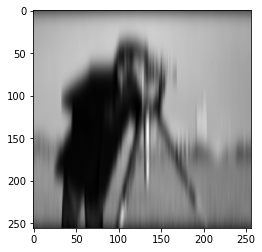

In [24]:
A_conv_1D = gauss_convolve_1D(A, 10)
_ = plt.imshow(np.real(A_conv_1D), cmap='gray')

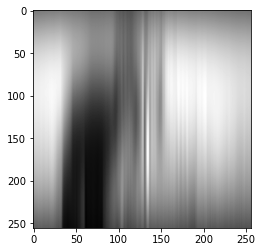

In [25]:
A_conv_1D = gauss_convolve_1D(A, 50)
_ = plt.imshow(np.real(A_conv_1D), cmap='gray')

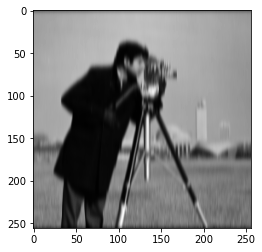

In [26]:
A_conv_1D = gauss_convolve_1D(A, 3)
_ = plt.imshow(np.real(A_conv_1D), cmap='gray')

`sigma` - параметр, отвечающий за дисперсию, то есть за "сплющенность" гауссова колокола. Если увеличить `sigma`, веса в центре распределения (то есть для ячеек ближе к исходному пикселю) - уменьшатся, а для более дальних - увеличатся. То есть вклад более дальних пикселей станет ощутимее, это и приведёт к меньшей чёткости объекта на картинке. Аналогично в другую сторону: чем меньше сигма, тем чётче объект.

### c. (7 баллов) Вычисление двумерной свертки

- **(5 баллов)** Теперь вы уже без труда сможете написать функцию двумерной свёртки...

In [27]:
def gauss_convolve_2D(A, sigma):
    """
        Input
            A: m x n matrix
            sigma: standard deviation of Gaussian filter

        Output
            С: m x n matrix, B = G_m @ A @ G_n.T
    """
    
    B = gauss_convolve_1D(A, sigma)
    C = gauss_convolve_1D(B.T, sigma).T
    
    return C

...и визуально проверить, правильно ли она работает.

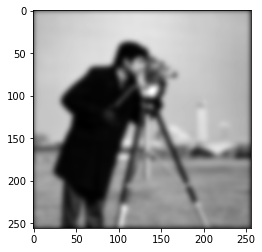

In [28]:
# работает ведь!
A_conv = gauss_convolve_2D(A, 3)
_ = plt.imshow(np.real(A_conv), cmap='gray')

- **(2 балла)** Объясните эффект тёмных полос около края картинки.

Тёмные полосы возникают из-за двух факторов: 1) Объект в центре кадра, пиксели которого мы берём с различными весами, значительно темнее исходных пикселей по краям + 2) Мы не делали искусственные поля для нашей картинки (не отражали изображение, например), то есть крайние пиксели могут получить веса только из частей ближе к центру, которые более тёмные. Из-за этого и возникает своеобразное виньетирование.

### d. (9 баллов) Обращение свёртки (deconvolution)

Представьте, что к вам попало изображение такого типа.

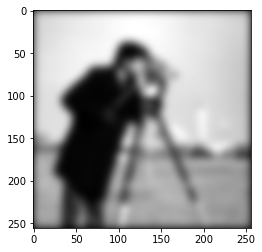

In [29]:
from scipy.ndimage import gaussian_filter
sigma = 5
A_conv = gauss_convolve_2D(A, sigma)
_ = plt.imshow(np.real(A_conv), cmap='gray')

Деталей не видно совсем. Чтобы восстановить их попробуем применить применить операцию обратную свертке. 
Мы уже знаем, что размытое изображение $A_{conv}$ вычисляется по формуле $A_{conv} = T_m A T_n^\top$.
Если же матрицы $T_m$ и $T_n$ обратимы, то можно обратить свёртку и получить обратно нашего cameraman:
$$
A = T_m^{-1} A_{conv} T_n^{-\top}.
$$

In [31]:
m, n = np.real(A_conv).shape
G_m, G_n = form_T(m, sigma), form_T(n, sigma)
B = np.linalg.solve(G_m, np.real(A_conv))
A_rec = np.linalg.solve(G_n, B.T).T

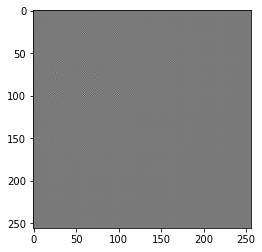

In [32]:
_ = plt.imshow(A_rec, cmap='gray')

Непохоже на исходное изображение. В чём может быть дело?
Давайте выведем сингулярные числа матрицы $G_m$.

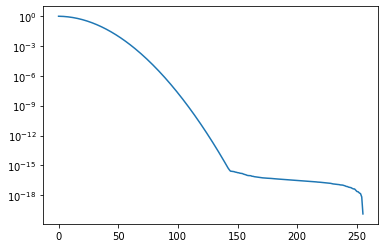

In [33]:
s = np.linalg.svd(G_m, compute_uv=False)
plt.plot(s)
_ = plt.semilogy()

Видно, что у нас большие проблемы (хотя пока мы не умеем это формализовывать), потому что матрица очень близка к вырожденной. Специально для таких матриц у нас есть инструмент псевдообратных матриц, но чтобы оправдать его применение, нужно сначала свести задачу вычисления матрицы $A$ к задаче решения системы линейных уравнений. 
Для этого вспомним формулу, связанную с Кронекеровым произведением: 
$$
\mathrm{vec}(A_{conv}) = (T_n \otimes T_m)\,\mathrm{vec}(A).
$$
Теперь уже можно вычислить приближённый $\mathrm{vec}(A)$ с помощью псевдообратных:
$$
\mathrm{vec}(\tilde{A}) = (T_n \otimes T_m)^+ \,\mathrm{vec}(A_{conv})
$$

Конечно, мы не хотим формировать матрицу размеров $mn \times mn$ и работать с ней, поэтому воспользуемся (без док-ва) тем фактом, что
$$
(T_n \otimes T_m)^+ = T_n^+ \otimes T_m^+.
$$
Теперь можно перейти обратно к матричной записи: 
$$
\tilde{A} = T_m^+ A_{conv} (T_n^+)^\top.
$$

- **(9 баллов)** Реализуйте функцию ```inverse_gauss_convolve_2D```, которая реконструирут изображение по "смазанной" картинке $A_{conv}$ с помощью псевдообратных матриц от матриц $T_m$ и $T_n$, у которых занулили сингулярные числа меньше ```tol```.

In [34]:
from scipy.linalg import pinv2

def inverse_gauss_convolve_2D(A_conv, sigma, tol):
    """
        Input
            conv: m x n matrix -- result of convolution with
                  a Gaussian filter
            sigma: standard deviation of Gaussian filter
            tol: tolerance for cutting singular values in pseudoinverse

        Output
            A_rec: m x n reconstructed matrix, such that approximately A_conv = T_m @ A_rec @ T_n.T
    """
    m, n = np.real(A_conv).shape
    T_m, T_n = form_T(m, sigma), form_T(n, sigma)
    T_m_pinv = pinv2(T_m, cond=tol)
    T_n_pinv = pinv2(T_n, cond=tol)
    A_rec = T_m_pinv @ A_conv @ T_n_pinv.T
    
    
    #B = np.linalg.solve(G_m, np.real(A_conv))
    #A_rec = np.linalg.solve(G_n, B.T).T
    
    return A_rec

Посмотрим на получившийся результат.

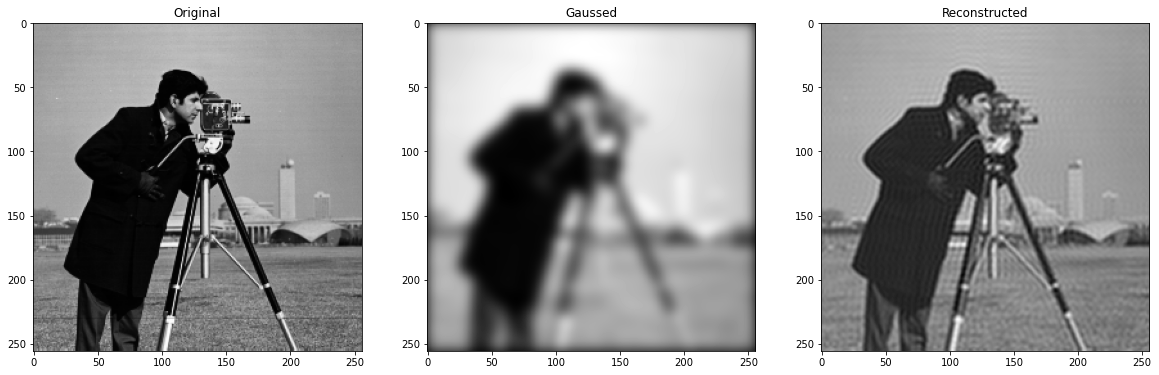

In [36]:
fig, axs = plt.subplots(1,3, figsize=(20,10))
axs[0].imshow(A, cmap='gray')
axs[0].set_title("Original")
axs[1].imshow(np.real(A_conv), cmap='gray')
axs[1].set_title("Gaussed")
A_rec = inverse_gauss_convolve_2D(A_conv, sigma, 1e-8)
axs[2].imshow(np.real(A_rec), cmap='gray')
_ = axs[2].set_title("Reconstructed")